# BRW Estimation

Replication code of the BRW shock by Bu, Wu, and Rogers (2021).

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS

maturity = 2
year = 2020
month = 12
monthname = "Dec"
MAR2020 = 0

## 1. Calculating the difference of the 2-year Treasury series (DGS2)

Load the data and rename columns

In [2]:
data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\USA\DGS2.xls")
data.rename(columns={"observation_date": "date"}, inplace=True)
data.sort_values(by='date', inplace=True)
data.replace(0, method='ffill', inplace=True)

Convert date to datetime format and create additional date-related columns

In [3]:
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["mdate"] = data["date"].dt.to_period("M")

Filter data for the specified period (up to September 2019 - Cut-off date used for the estimation in the research paper.)

In [4]:
data = data[data["mdate"] <= pd.Period("2019-09")]
data = data[data["mdate"] >= pd.Period("1994-01")]

Calculate the difference of the series (dgs_d)

In [5]:
data["dgs_d"] = data["DGS" + str(maturity)] - data["DGS" + str(maturity)].shift(1)

Set "mdate" as the index and convert it to a time series

In [6]:
data.set_index("mdate", inplace=True)
data.index = pd.to_datetime(data.index.to_timestamp())

Drop unnecessary columns

In [7]:
data.drop(columns=["year", "month", "day"], inplace=True)
data.head()

,date,DGS2,dgs_d
mdate,,,
1994-01-01,1994-01-03,4.30,NaN
1994-01-01,1994-01-04,4.29,-0.01
1994-01-01,1994-01-05,4.31,0.02
1994-01-01,1994-01-06,4.24,-0.07
1994-01-01,1994-01-07,4.09,-0.15


Save the resulting DataFrame to a new file

In [8]:
data.to_pickle("temp.pkl")

## 2. Adding FOMC dates

Load the FOMC dates from the Excel file

In [9]:
fomc_dates = pd.read_excel("C:/Users/Alysson/Documents/GitHub/Monetary-Shocks/USA/FOMCdate.xlsx")
fomc_dates.rename(columns={"date": "FOMC_date"}, inplace=True)

Convert date to datetime format and create additional date-related columns

In [10]:
fomc_dates["FOMC_date"] = pd.to_datetime(fomc_dates["FOMC_date"])
fomc_dates["year"] = fomc_dates["FOMC_date"].dt.year
fomc_dates["month"] = fomc_dates["FOMC_date"].dt.month
fomc_dates["day"] = fomc_dates["FOMC_date"].dt.day
fomc_dates["mdate"] = fomc_dates["FOMC_date"].dt.to_period("M")

MAR2020 = 0

if MAR2020 == 0:
    fomc_dates = fomc_dates[~((fomc_dates["year"] == 2020) & (fomc_dates["month"] == 3) & (fomc_dates["day"] == 15))]


Drop unnecessary columns

In [11]:
fomc_dates.drop(columns=["year", "month", "day"], inplace=True)

Load the previous DataFrame "temp.dta" 

In [12]:
temp_data = pd.read_pickle("temp.pkl")

Merge the two DataFrames on the 'date' column

In [13]:
merged_data = pd.merge(temp_data, fomc_dates, how="inner", left_on="date", right_on="FOMC_date")

Drop rows where 'q' is missing (denoted as NaN)

In [14]:
merged_data = merged_data.dropna(subset=["q"])

Replace missing values (NaN) in 'q' with 0

In [15]:
merged_data["q"].fillna(0, inplace=True)
merged_data.head()

,date,DGS2,dgs_d,FOMC_date,q,mdate
0,1994-02-04,4.42,0.14,1994-02-04,1,1994-02
1,1994-02-11,4.44,-0.01,1994-02-11,0,1994-02
2,1994-03-22,5.03,-0.06,1994-03-22,1,1994-03
3,1994-03-29,5.19,0.07,1994-03-29,0,1994-03
4,1994-05-17,5.88,-0.15,1994-05-17,1,1994-05


Save the merged DataFrame to a new file

In [16]:
merged_data.to_pickle("temp.pkl")

## 3. Estimation

Load the data from "feds200628.csv" 

In [17]:
yield_data = pd.read_csv(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\USA\feds200628.csv")

Convert 'date' column to datetime format and keeping only necessary columns

In [18]:
yield_data['date'] = pd.to_datetime(yield_data['Date'], format='%Y-%m-%d')
yield_data.sort_values(by='date', inplace=True)
yield_data.loc[:, 'SVENY01':'SVENY30'] = yield_data.loc[:, 'SVENY01':'SVENY30'].fillna(method='ffill')

In [19]:
yield_data['year'] = yield_data['date'].dt.year
yield_data['month'] = yield_data['date'].dt.month
yield_data['day'] = yield_data['date'].dt.day
yield_data['date'] = pd.to_datetime(yield_data[['year', 'month', 'day']])
yield_data['mdate'] = yield_data['date'].dt.to_period('M')
yield_data = yield_data[['date', 'mdate'] + [col for col in yield_data.columns if col.startswith('SVENY')]]
yield_data = yield_data[yield_data['mdate'] >= pd.Period('1994-01')]

Create a list for all maturities of the treasuries

Calculate differences for each maturity

In [20]:
list_maturities = [str(i).zfill(2) for i in range(1, 31)]

for num in list_maturities:
    col_name = f'SVENY{num}'
    yield_data[f'{col_name}_d'] = yield_data[col_name].diff()
selected_columns = yield_data.iloc[:, -30:]

Create aligned_dgs_d column

In [21]:
data_complete = merged_data.merge(yield_data, on=['date','mdate'], how='inner')
data_complete.head()

,date,DGS2,dgs_d,FOMC_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,SVENY21_d,SVENY22_d,SVENY23_d,SVENY24_d,SVENY25_d,SVENY26_d,SVENY27_d,SVENY28_d,SVENY29_d,SVENY30_d
0,1994-02-04,4.42,0.14,1994-02-04,1,1994-02,3.865749,4.369629,4.744739,5.047987,...,0.035375,0.028441,0.022022,0.016079,0.010570,0.005457,0.000704,-0.003722,-0.007851,-0.011711
1,1994-02-11,4.44,-0.01,1994-02-11,0,1994-02,3.900780,4.405665,4.795111,5.103778,...,-0.032590,-0.032605,-0.032620,-0.032637,-0.032654,-0.032672,-0.032691,-0.032709,-0.032727,-0.032745
2,1994-03-22,5.03,-0.06,1994-03-22,1,1994-03,4.443199,5.001075,5.396750,5.697230,...,-0.076686,-0.075292,-0.074018,-0.072847,-0.071769,-0.070774,-0.069852,-0.068995,-0.068197,-0.067453
3,1994-03-29,5.19,0.07,1994-03-29,0,1994-03,4.526711,5.186564,5.626675,5.952448,...,0.082017,0.081543,0.081109,0.080710,0.080344,0.080005,0.079691,0.079400,0.079129,0.078875
4,1994-05-17,5.88,-0.15,1994-05-17,1,1994-05,5.301464,5.864555,6.191343,6.429637,...,-0.172195,-0.166615,-0.161111,-0.155718,-0.150464,-0.145369,-0.140451,-0.135722,-0.131189,-0.126857


### Step 1 - 2SLS

In [22]:
### Creating IV

mask_q0 = data_complete["q"] == 0
mask_q1 = data_complete["q"] == 1
data_complete["const"] = 1
data_complete["iv"] = data_complete[mask_q1]["dgs_d"]
data_complete.loc[mask_q0, "iv"] = -1 * data_complete.loc[mask_q0, "dgs_d"]

In [23]:
for num in list_maturities:
    col_name = f'SVENY{num}_d'
    model = IV2SLS(dependent=data_complete[col_name], endog=data_complete["dgs_d"], exog=data_complete[["const"]], instruments=data_complete["iv"])
    results = model.fit()
    data_complete[f"beta_hat{num}"]=results.params["dgs_d"]
    print(results)
data_complete.head()

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.8182
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8178
No. Observations:                 422   F-statistic:                    228.00
Date:                Wed, Dec 13 2023   P-value (F-stat)                0.0000
Time:                        21:31:05   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0004     0.0010     0.4495     0.6531     -0.0015      0.0023
dgs_d          0.8318     0.0551     15.100     0.00

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY09_d   R-squared:                      0.4998
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4986
No. Observations:                 422   F-statistic:                    12.402
Date:                Wed, Dec 13 2023   P-value (F-stat)                0.0004
Time:                        21:31:06   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0017     0.0020     0.8648     0.3872     -0.0022      0.0057
dgs_d          0.6940     0.1971     3.5216     0.00

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY20_d   R-squared:                      0.2076
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2057
No. Observations:                 422   F-statistic:                    2.7560
Date:                Wed, Dec 13 2023   P-value (F-stat)                0.0969
Time:                        21:31:06   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0010     0.0023     0.4339     0.6644     -0.0035      0.0054
dgs_d          0.2400     0.1445     1.6601     0.09

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY29_d   R-squared:                      0.0987
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0966
No. Observations:                 422   F-statistic:                    0.6609
Date:                Wed, Dec 13 2023   P-value (F-stat)                0.4163
Time:                        21:31:06   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const      -2.554e-06     0.0024    -0.0011     0.9991     -0.0047      0.0047
dgs_d          0.1213     0.1492     0.8129     0.41

,date,DGS2,dgs_d,FOMC_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat21,beta_hat22,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30
0,1994-02-04,4.42,0.14,1994-02-04,1,1994-02,3.865749,4.369629,4.744739,5.047987,...,0.218667,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301
1,1994-02-11,4.44,-0.01,1994-02-11,0,1994-02,3.900780,4.405665,4.795111,5.103778,...,0.218667,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301
2,1994-03-22,5.03,-0.06,1994-03-22,1,1994-03,4.443199,5.001075,5.396750,5.697230,...,0.218667,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301
3,1994-03-29,5.19,0.07,1994-03-29,0,1994-03,4.526711,5.186564,5.626675,5.952448,...,0.218667,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301
4,1994-05-17,5.88,-0.15,1994-05-17,1,1994-05,5.301464,5.864555,6.191343,6.429637,...,0.218667,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301


### Step 2 - Fama and MacBeth

In [24]:
data_complete = data_complete.loc[mask_q0]
maxt = len(data_complete)

aligned_dgs_d = []
for num in range(maxt):
    sveny_values = data_complete.iloc[num, data_complete.columns.get_loc("SVENY01_d"):data_complete.columns.get_loc("SVENY30_d") + 1].values.astype(float)
    beta_values = data_complete.iloc[num, data_complete.columns.get_loc("beta_hat01"):data_complete.columns.get_loc("beta_hat30") + 1].values.astype(float)

    # Adicionando uma constante à matriz independente (para o termo constante na regressão)
    X = sm.add_constant(beta_values)

    # Realizando a regressão usando o OLS do StatsModels
    model = sm.OLS(sveny_values, X)
    results = model.fit()

    # Imprimindo os coeficientes beta estimados
    aligned_dgs_d.append(results.params[1:])

data_complete["new_shock"]=aligned_dgs_d
data_complete["new_shock"] = data_complete["new_shock"].apply(lambda x: x[0])

In [25]:
data_complete

,date,DGS2,dgs_d,FOMC_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat22,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30,new_shock
1,1994-02-11,4.44,-0.01,1994-02-11,0,1994-02,3.900780,4.405665,4.795111,5.103778,...,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301,0.015739
3,1994-03-29,5.19,0.07,1994-03-29,0,1994-03,4.526711,5.186564,5.626675,5.952448,...,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301,-0.000033
5,1994-05-24,5.94,0.00,1994-05-24,0,1994-05,5.269337,5.886217,6.256663,6.510579,...,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301,0.038338
7,1994-07-13,6.22,-0.02,1994-07-13,0,1994-07,5.529833,6.159627,6.525361,6.776893,...,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301,-0.006872
9,1994-08-23,6.26,-0.01,1994-08-23,0,1994-08,5.574120,6.165206,6.495721,6.714952,...,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301,-0.016497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2019-03-27,2.22,-0.02,2019-03-27,0,2019-03,2.356000,2.219600,2.169100,2.167800,...,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301,0.032052
415,2019-05-08,2.30,0.02,2019-05-08,0,2019-05,2.366600,2.281200,2.256100,2.266200,...,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301,-0.008562
417,2019-06-26,1.77,0.06,2019-06-26,0,2019-06,1.961200,1.798900,1.758300,1.776100,...,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301,0.031274
419,2019-08-07,1.59,-0.01,2019-08-07,0,2019-08,1.782600,1.592500,1.525000,1.515600,...,0.199654,0.182882,0.168211,0.155421,0.144619,0.13534,0.127766,0.12125,0.116301,0.021219


### Renormalization

In [26]:
renormalization = sm.OLS(data_complete["dgs_d"], data_complete["new_shock"])
results_renormalization = renormalization.fit()
beta_estimado = results_renormalization.params["new_shock"]
data_complete["BRW_daily"]=data_complete["new_shock"]*beta_estimado 
#print(results_renormalization.summary())


In [27]:
BRW_regression = sm.OLS(data_complete["dgs_d"], data_complete["BRW_daily"])
results_BRW_regression = BRW_regression.fit()
print(results_BRW_regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                  dgs_d   R-squared (uncentered):                   0.161
Model:                            OLS   Adj. R-squared (uncentered):              0.157
Method:                 Least Squares   F-statistic:                              40.38
Date:                Wed, 13 Dec 2023   Prob (F-statistic):                    1.28e-09
Time:                        21:31:09   Log-Likelihood:                          380.79
No. Observations:                 211   AIC:                                     -759.6
Df Residuals:                     210   BIC:                                     -756.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

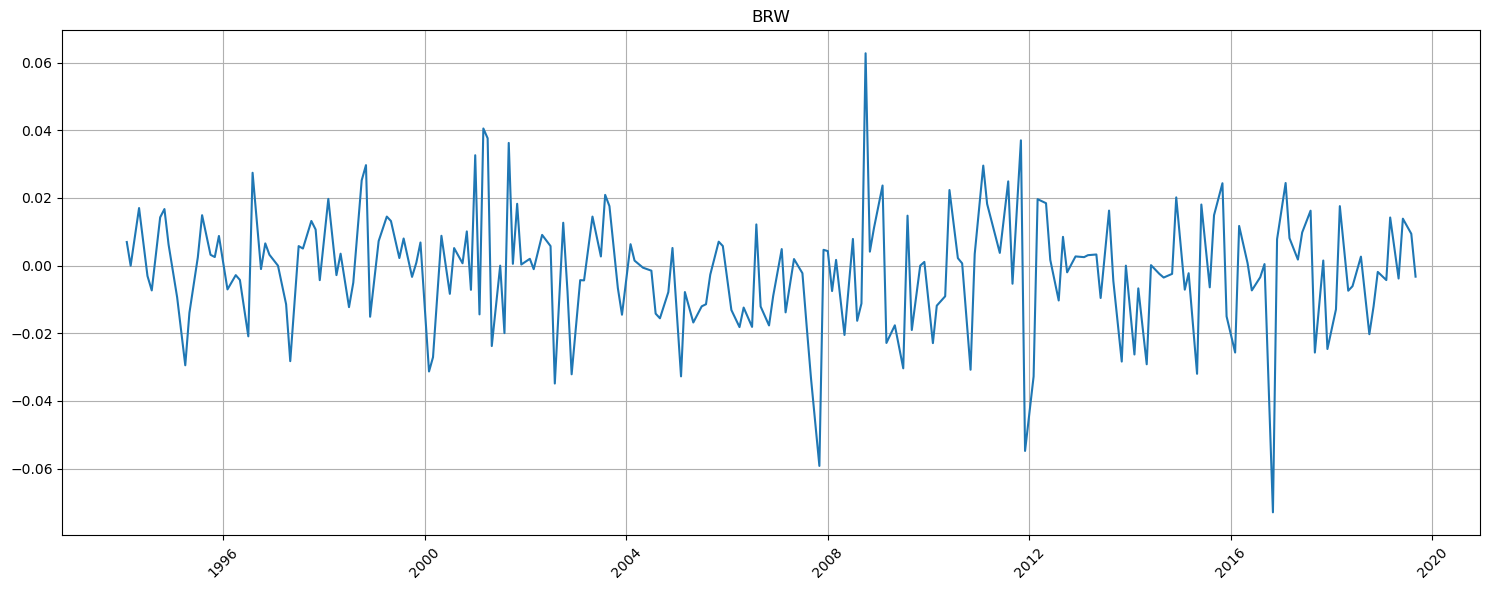

In [31]:
# Converter valores do tipo Period para datetime
mdate_values = data_complete["mdate"].dt.to_timestamp()
new_shock_values = data_complete["BRW_daily"]

# Criar um gráfico de linha
plt.figure(figsize=(15, 6))
plt.plot(mdate_values, new_shock_values)
plt.title("BRW")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
data_complete["BRW_daily"]

1      0.006990
3     -0.000015
5      0.017026
7     -0.003052
9     -0.007326
         ...   
413    0.014234
415   -0.003802
417    0.013889
419    0.009423
421   -0.003254
Name: BRW_daily, Length: 211, dtype: float64

In [40]:
# Definir a data de início e a data de término
start_date = pd.to_datetime("1994-01-01")
end_date = pd.to_datetime("2019-09-01")  # Especifique a data de término desejada

# Criar um intervalo de datas mensais até a data de término
date_range = pd.date_range(start=start_date, end=end_date, freq="M")

# Criar um DataFrame com a coluna de datas
data_monthly = pd.DataFrame({'mdate': date_range})

# Formatar as datas no estilo "1994-02"
data_monthly['mdate'] = data_monthly['mdate'].dt.strftime('%Y-%m')

columns = data_complete[['mdate', 'BRW_daily']]


columns.isetitem(columns.columns.get_loc('mdate'), columns['mdate'].dt.strftime('%Y-%m'))

data_monthly = data_monthly.merge(columns, on='mdate', how='left')
data_monthly['BRW_daily'].fillna(0, inplace=True)


# Imprimir as primeiras linhas do DataFrame
print(data_monthly)

       mdate  BRW_daily
0    1994-01   0.000000
1    1994-02   0.006990
2    1994-03  -0.000015
3    1994-04   0.000000
4    1994-05   0.017026
..       ...        ...
303  2019-04   0.000000
304  2019-05  -0.003802
305  2019-06   0.013889
306  2019-07   0.000000
307  2019-08   0.009423

[308 rows x 2 columns]


In [41]:
subset_data = data_monthly

# Especifique o nome do arquivo Excel de saída
output_file = "data_subset2.xlsx"

# Salve o DataFrame no arquivo Excel
subset_data.to_excel(output_file, index=False)